# Set-up

In [2]:
# imports
import pandas as pd
import altair as alt
import os


# Data Cleaning

### First, we'll make a clean dataframe with years as the index from 1970 to 2022

In [3]:
# make the empty dataframe with years and months from 1970 to 2022 as the index
df = pd.DataFrame(
    index=pd.MultiIndex.from_product(
        [range(1970, 2023), range(1, 13)], names=["year", "month"]
    )
)

# add a year_month column
df["date"] = df.index.to_series().apply(lambda x: str(x[0]) + "-" + str(x[1]).zfill(2))

# convert the year_month column to a datetime object
df["date"] = pd.to_datetime(df["date"], format="%Y-%m")

# reset the structure so the dataframe is only the date column
df = df.reset_index(drop=True)

df.head(10)


,date
0,1970-01-01
1,1970-02-01
2,1970-03-01
3,1970-04-01
4,1970-05-01
5,1970-06-01
6,1970-07-01
7,1970-08-01
8,1970-09-01
9,1970-10-01


### Next, we'll need to configure the US census data by taking the overall US population and smoothing for missing years in between census reports

In [4]:
# ingest the census data
census_df = pd.read_excel(
    "../00_source_data/population-change-data-table.xlsx", skiprows=3
)
# keep only census columns
census_df = census_df[
    [
        "Area",
        "1910 Census",
        "1920 Census",
        "1930 Census",
        "1940 Census",
        "1950 Census",
        "1960 Census",
        "1970 Census",
        "1980 Census",
        "1990 Census",
        "2000 Census",
        "2010 Census",
        "2020 Census",
    ]
]

# rename the mispelled United States1 to US
census_df.loc[census_df["Area"] == "United States1", "Area"] = "US"

# Pull out only the US row
census_df = census_df[census_df["Area"] == "US"]

# pivot the census data
census_df = census_df.melt(id_vars=["Area"], var_name="Year", value_name="Population")

# convert the year column to a datetime
census_df["date"] = pd.to_datetime(census_df["Year"], format="%Y Census")

# convert the date column to a datetime object
census_df["date"] = pd.to_datetime(census_df["date"], format="%Y")

# drop the Area column
census_df = census_df.drop(columns=["Area", "Year"])

# convert the population column to an integer
census_df["Population"] = census_df["Population"].astype(int)

# filter for just the years after 1949
census_df = census_df[census_df["date"] > "1969-12-31"]

# reset the index
census_df = census_df.reset_index(drop=True)

census_df.head(10)


,Population,date
0,203211926,1970-01-01
1,226545805,1980-01-01
2,248709873,1990-01-01
3,281421906,2000-01-01
4,308745538,2010-01-01
5,331449281,2020-01-01


### Add the electricty generation data

In [5]:
elec_df = pd.read_csv("../00_source_data/MER_T07_02A.csv")

# split the YYYYMM column into a year and month column
elec_df["year"] = elec_df["YYYYMM"].apply(lambda x: int(str(x)[:4]))
elec_df["month"] = elec_df["YYYYMM"].apply(lambda x: int(str(x)[4:]))

# drop all rows where month equals 13
elec_df = elec_df[elec_df["month"] != 13]

# make a date column from the year and month columns
elec_df["date"] = pd.to_datetime(
    elec_df["year"].astype(str) + "-" + elec_df["month"].astype(str).str.zfill(2)
)

# makes sure the date is a datetime object
elec_df["date"] = pd.to_datetime(elec_df["date"])

# drop the where Value equals not available
elec_df = elec_df[elec_df["Value"] != "Not Available"]

# convert value to an integer
elec_df["Value"] = elec_df["Value"].astype(float)

# groupby date and sum the electricity generation
elec_df = elec_df.groupby("date").sum().reset_index()

# keep the date and value columns
elec_df = elec_df[["date", "Value"]]

# rename value to generation
elec_df = elec_df.rename(columns={"Value": "generation"})

elec_df.head(10)


/var/folders/79/hh7cth4s3p3dbtdpc8j1m9bm0000gn/T/ipykernel_42460/2637009484.py:25: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  elec_df = elec_df.groupby("date").sum().reset_index()


,date,generation
0,1973-01-01,320435.977
1,1973-02-01,287077.399
2,1973-03-01,296316.739
3,1973-04-01,279178.880
4,1973-05-01,294790.247
5,1973-06-01,322487.348
6,1973-07-01,347466.015
7,1973-08-01,354730.728
8,1973-09-01,313750.065
9,1973-10-01,308394.932


#### Now we have the vehicle efficiency data

In [6]:
veh_df = pd.read_csv("../00_source_data/MER_T01_08.csv")

# subset for the rows where unit is Miles per Gallon
veh_df = veh_df[veh_df["Unit"] == "Miles per Gallon"]

# keep Descriptions where the value is All Motor Vehicles Fuel Economy
veh_df = veh_df[veh_df["Description"] == "All Motor Vehicles Fuel Economy"]

# split the YYYYMM column into two columns
veh_df["Year"] = veh_df["YYYYMM"].astype(str).str[:4]
veh_df["Month"] = veh_df["YYYYMM"].astype(str).str[4:]

# if the month column is 13 make it 1
veh_df.loc[veh_df["Month"] == "13", "Month"] = "1"

# make a date column from year and month columns and add the day as 01
veh_df["date"] = pd.to_datetime(
    veh_df["Year"].astype(str) + "-" + veh_df["Month"].astype(str) + "-01"
)

# keep the Value and Year columns
veh_df = veh_df[["Value", "date"]]

# Rename the value column to Veh_MPG
veh_df = veh_df.rename(columns={"Value": "Veh_MPG"})

# convert Veh_MPG to a float
veh_df["Veh_MPG"] = veh_df["Veh_MPG"].astype(float)

# groupby year and take the mean
veh_df = veh_df.groupby("date").mean()

# filter to only years after 1972
veh_df = veh_df[veh_df.index > "1972-12-31"]

# reset the index
veh_df = veh_df.reset_index()

veh_df.head(10)


,date,Veh_MPG
0,1973-01-01,11.9
1,1974-01-01,12.0
2,1975-01-01,12.2
3,1976-01-01,12.1
4,1977-01-01,12.3
5,1978-01-01,12.4
6,1979-01-01,12.5
7,1980-01-01,13.3
8,1981-01-01,13.6
9,1982-01-01,14.1


### NOAA Weather data is added

In [7]:
# create a loop to read in all the csv files in the folder and merge them into one dataframe
# create a list of the files in the folder
files = os.listdir("../00_source_data/NOAA_data")

# create an empty list to hold the dataframes
dfs = []

# loop through the files
for file in files:
    # read in the csv file
    tempdf = pd.read_csv("../00_source_data/NOAA_data/" + file, skiprows=4)
    # append the dataframe to the list
    dfs.append(tempdf)

# merge the dataframes into one dataframe
noaa_df = pd.concat(dfs)

# convert the date column to a datetime object of month and year
noaa_df["date"] = pd.to_datetime(noaa_df["Date"], format="%Y%m")

# rename Value to AvgTemp
noaa_df = noaa_df.rename(columns={"Value": "AvgTemp"})

# drop the date and anomaly columns
noaa_df = noaa_df.drop(columns=["Date", "Anomaly"])

# drop years before 1973
noaa_df = noaa_df[noaa_df["date"] > "1972-12-31"].reset_index(drop=True)

# switch the column order
noaa_df = noaa_df[["date", "AvgTemp"]]

noaa_df.head(20)


,date,AvgTemp
0,1973-03-01,44.29
1,1974-03-01,44.38
2,1975-03-01,38.70
3,1976-03-01,42.31
4,1977-03-01,43.18
5,1978-03-01,41.31
6,1979-03-01,42.06
7,1980-03-01,39.36
8,1981-03-01,42.85
9,1982-03-01,42.03


### Add electric vehicle sales data

In [8]:
ev_df = pd.read_excel("../00_source_data/afv_vehicle_data.xlsx")

# drop the first column
# ev_df = ev_df.drop(columns=["Unnamed: 0"])

# pivot the dataframe to put columns as rows and vice versa
ev_df = ev_df.melt(id_vars=["Unnamed: 0"], var_name="year", value_name="ev_sales")

# drop dows where sales is z
ev_df = ev_df[ev_df["ev_sales"] != "Z"]

# drop the unnamed column
ev_df = ev_df.drop(columns=["Unnamed: 0"])

# groupby year and sum the sales
ev_df = ev_df.groupby("year").sum().reset_index()

# rename the year column to date
ev_df = ev_df.rename(columns={"year": "date"})

# convert the date column to a datetime object
ev_df["date"] = pd.to_datetime(ev_df["date"], format="%Y")

ev_df.head(10)


,date,ev_sales
0,2000-01-01,9350
1,2001-01-01,20282
2,2002-01-01,36042
3,2003-01-01,47566
4,2004-01-01,84233
5,2005-01-01,205876
6,2006-01-01,251864
7,2007-01-01,351071
8,2008-01-01,315763
9,2009-01-01,290273


# Data Merging

### Now we merge data starting with the census

,date,Population
36,1973-01-01,2.102121e+08
37,1973-02-01,2.104065e+08
38,1973-03-01,2.106010e+08
39,1973-04-01,2.107954e+08
40,1973-05-01,2.109899e+08


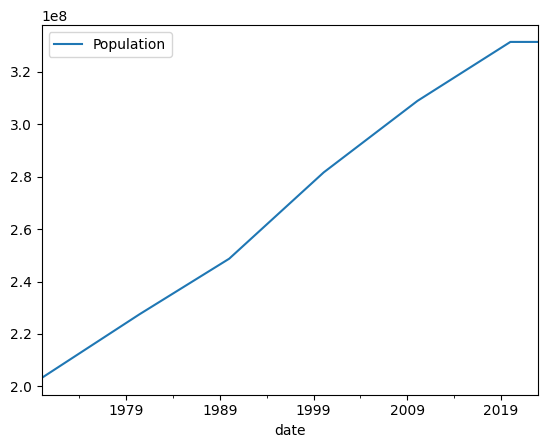

In [9]:
# merge the census data with the empty dataframe
merged_df = pd.merge(df, census_df, on="date", how="left")
# smooth the population column
merged_df["Population"] = merged_df["Population"].interpolate()
merged_df.plot(x="date", y="Population")

# # filter the data to include only the years after 1972
merged_df = merged_df[merged_df["date"] > "1972-12-31"]

merged_df.head()


### Now we add energy production data

,date,Population,generation
0,1973-01-01,2.102121e+08,320435.977
1,1973-02-01,2.104065e+08,287077.399
2,1973-03-01,2.106010e+08,296316.739
3,1973-04-01,2.107954e+08,279178.880
4,1973-05-01,2.109899e+08,294790.247


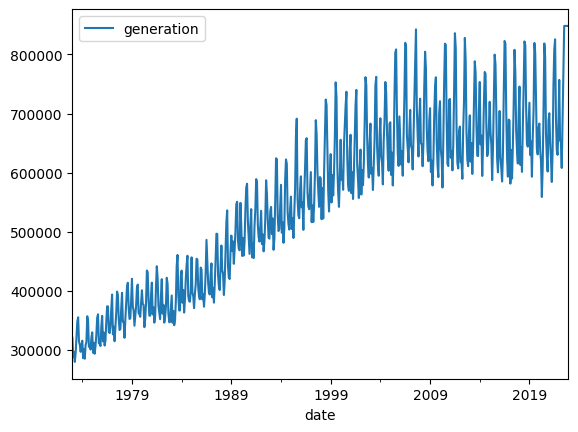

In [10]:
# merge the energy data with the merged dataframe
merged_df2 = pd.merge(merged_df, elec_df, on="date", how="left").copy()
# smooth the energy column
merged_df2["generation"] = merged_df2["generation"].interpolate()
merged_df2.plot(x="date", y="generation")

merged_df2.head()


### This merge will be the vehicle efficiency data

,date,Population,generation,Veh_MPG
0,1973-01-01,2.102121e+08,320435.977,11.900000
1,1973-02-01,2.104065e+08,287077.399,11.908333
2,1973-03-01,2.106010e+08,296316.739,11.916667
3,1973-04-01,2.107954e+08,279178.880,11.925000
4,1973-05-01,2.109899e+08,294790.247,11.933333


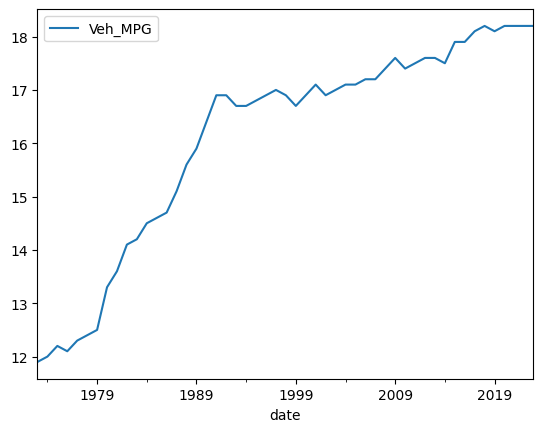

In [11]:
# merge vehicle data
merged_df3 = pd.merge(merged_df2, veh_df, on="date", how="left").copy()
# smooth the vehicle column
merged_df3["Veh_MPG"] = merged_df3["Veh_MPG"].interpolate()
merged_df3.plot(x="date", y="Veh_MPG")

merged_df3.head()


### Add NOAA average temp to the overall df

,date,Population,generation,Veh_MPG,AvgTemp
0,1973-01-01,2.102121e+08,320435.977,11.900000,29.59
1,1973-02-01,2.104065e+08,287077.399,11.908333,33.58
2,1973-03-01,2.106010e+08,296316.739,11.916667,44.29
3,1973-04-01,2.107954e+08,279178.880,11.925000,48.83
4,1973-05-01,2.109899e+08,294790.247,11.933333,59.23


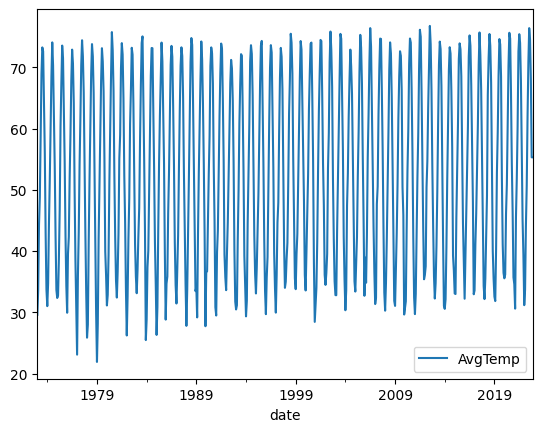

In [12]:
# merge the NOAA df on date
merged_df4 = pd.merge(merged_df3, noaa_df, on="date", how="left").copy()

# # smooth the temperature column
merged_df4["AvgTemp"] = merged_df4["AvgTemp"].interpolate()
merged_df4.plot(x="date", y="AvgTemp")

merged_df4.head()


### Add the ev sales data to the merged df

,date,Population,generation,Veh_MPG,AvgTemp,ev_sales
0,1973-01-01,2.102121e+08,320435.977,11.900000,29.59,0.0
1,1973-02-01,2.104065e+08,287077.399,11.908333,33.58,0.0
2,1973-03-01,2.106010e+08,296316.739,11.916667,44.29,0.0
3,1973-04-01,2.107954e+08,279178.880,11.925000,48.83,0.0
4,1973-05-01,2.109899e+08,294790.247,11.933333,59.23,0.0
5,1973-06-01,2.111843e+08,322487.348,11.941667,68.95,0.0
6,1973-07-01,2.113788e+08,347466.015,11.950000,73.26,0.0
7,1973-08-01,2.115732e+08,354730.728,11.958333,72.61,0.0
8,1973-09-01,2.117677e+08,313750.065,11.966667,64.40,0.0
9,1973-10-01,2.119621e+08,308394.932,11.975000,56.07,0.0


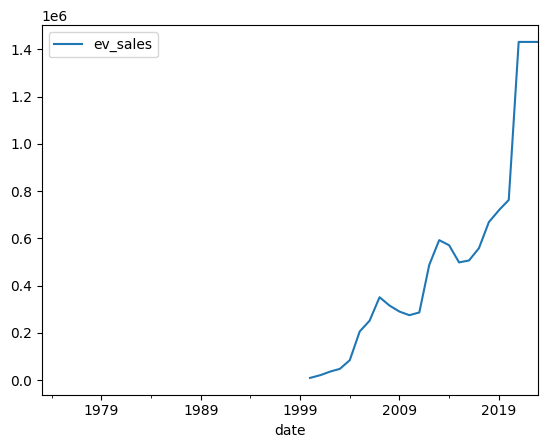

In [13]:
# merge df4 and the ev_df on date
merged_df5 = pd.merge(merged_df4, ev_df, on="date", how="left").copy()

# # smooth the ev_sales column
merged_df5["ev_sales"] = merged_df5["ev_sales"].interpolate()
merged_df5.plot(x="date", y="ev_sales")

# replace the nan ev_sales with 0
merged_df5["ev_sales"] = merged_df5["ev_sales"].fillna(0)

merged_df5.head(10)


# Output File as a CSV

In [14]:
# save merged df4 to a csv in the 20_clean_data_directory
merged_df5.to_csv("../20_clean_data/merged_dataset.csv", index=False)
